In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
# from google.colab import drive
import psutil


seed = 1234
tf.random.set_seed(seed)
# drive.mount('/content/drive')

In [2]:
def preprocess_images(images):
  imgs = np.zeros((images.shape[0], 100, 160))
  for i in range(images.shape[0]):
    imgs[i] = np.hstack((images[i, 0], images[i, 1]))
  imgs = imgs.reshape((images.shape[0], 100, 160, 1)) / 255.
  return np.where(imgs > .001, 1.0, 0.0).astype('float32')

In [3]:
images = np.load('images.npy', mmap_mode="r")
targets = np.load('targets.npy', mmap_mode="r")

In [5]:
images.shape

(6648700, 2, 100, 80)

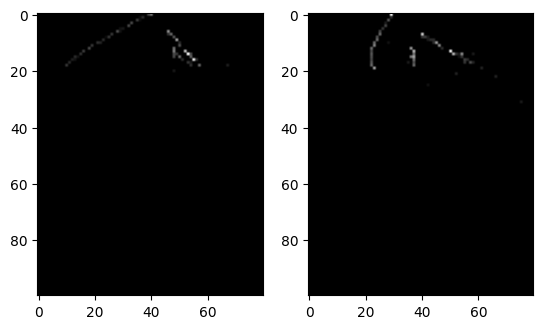

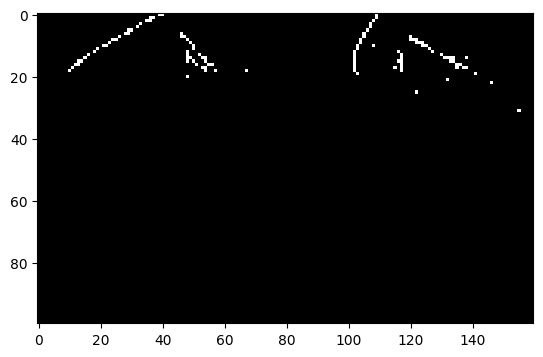

In [6]:
ind = 5
imgs = images[:32]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(imgs[ind, 0], cmap=plt.cm.gray)
axes[1].imshow(imgs[ind, 1], cmap=plt.cm.gray)
plt.show()

processed_imgs = preprocess_images(imgs)
plt.imshow(processed_imgs[ind], cmap=plt.cm.gray)
plt.show()

In [7]:
class convBlock(tf.keras.layers.Layer):
    def __init__(self, filters, size=3):
        super(convBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=size, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=2 * filters, kernel_size=1)
        self.conv3 = tf.keras.layers.Conv2D(filters=filters, kernel_size=1)
        self.activation = tf.keras.layers.ReLU()

    def call(self, inputs):
        result = self.conv1(inputs)
        result = self.conv2(result)
        # result = self.activation(result)
        result = self.conv3(result)
        result = self.activation(result)
        
        return result

In [109]:
class convolutionalVariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(convolutionalVariationalAutoencoder, self).__init__(latent_dim)
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(100, 160, 1)), 
            convBlock(filters=32, size=3),
            convBlock(filters=32, size=3),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2)), 
            convBlock(filters=64, size=3), 
            convBlock(filters=64, size=3), 
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2)), 
            convBlock(filters=128, size=3), 
            convBlock(filters=128, size=3),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(64), 
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim, )), 
            tf.keras.layers.Dense(64), 
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(24 * 39 * 128, activation="relu"), 
            tf.keras.layers.Reshape(target_shape=(24, 39, 128)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), activation='relu', output_padding=1),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [28]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
def kl_divergence(mean, logvar, raxis=1):
    kl = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=raxis)
    return kl


def compute_loss(model, x, beta):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.sample(z)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(x, x_logit, from_logits=True)
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)
    KL = kl_divergence(mean, logvar)
    return tf.reduce_mean(reconstruction_loss + KL * beta)


@tf.function
def train_step(model, x, optimizer, beta):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x, beta)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [30]:
latent_dim = 30
beta = 1e-4

In [ ]:
epoch_num = 0
min_loss = 999999999999
record = []

In [ ]:
for epochs in range(30, 110, 10):
    model = convolutionalVariationalAutoencoder(latent_dim)
    print(f"Epoch {epochs}:")

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print("\tTrain: ", end="")
        num = 1
        for train_ind in range(0, 5318784, 128):
            train_x = preprocess_images(images[train_ind: train_ind + 128])
            train_step(model, train_x, optimizer, beta)
            if train_ind // 53187 >= num:
                print("=", end="")
                num += 1
        print()
        end_time = time.time()

        eval_loss = tf.keras.metrics.Mean()

        print("\tEvaluation: ", end="")
        num = 1
        for eval_ind in range(0, 1329792, 128):
            eval_x = preprocess_images(images[5318784 + eval_ind: eval_ind + 128])
            eval_loss(compute_loss(model, eval_x, beta))
            if eval_ind // 13297 >= num:
                print("=", end="")
                num += 1
        print()
        eval_loss = eval_loss.result()
        print(f"\tEpoch: {epoch}, Evaluation set Loss: {eval_loss}, time elapse for current epoch: {(end_time - start_time) / 60:.2f}")

        # Check the loss value at the end of the epoch to see if it works normally===========================
        print("\tTest: ", end="")
        num = 1
        test_loss = tf.keras.metrics.Mean()
        for test_ind in range(0, 1329792, 128):
            test_x = preprocess_images(images[5318784 + test_ind: test_ind + 128])
            test_loss(compute_loss(model, test_x, beta))
            if test_ind // 13297 >= num:
                print("=", end="")
                num += 1
        print()
        #============================

    print("\tTest: ", end="")
    num = 1
    test_loss = tf.keras.metrics.Mean()
    for test_ind in range(0, 1329792, 128):
        test_x = preprocess_images(images[5318784 + test_ind: test_ind + 128])
        test_loss(compute_loss(model, test_x, beta))
        if test_ind // 13297 >= num:
            print("=", end="")
            num += 1
    print()
    test_loss = test_loss.result()
    record.append((epochs, test_loss))
    if test_loss < min_loss:
        min_loss = test_loss
        epoch_num = epochs
    model.encoder.save_weights(f"model_encoder_epoch_{epochs}.h5")
    model.decoder.save_weights(f"model_decoder_epoch_{epochs}.h5")

In [ ]:
print(f"Best Epoch = {epoch_num} with loss = {min_loss}")
with open("epochsRecord.txt", "w") as writer:
    for data in record:
        writer.write(f"Epochs = {data[0]}, Loss = {data[1]}\n")
    writer.write(f"Best Epoch = {epoch_num} with loss = {min_loss}\n")

In [ ]:
ind = 6648000
# ind = 0
imgs = preprocess_images(images[ind: ind + 32])

num = 4

plt.imshow(imgs[num], cmap=plt.cm.gray)
plt.show()

mean, logvar = model.encode(np.array([imgs[num]]))
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)[0]

plt.imshow(x_logit, cmap=plt.cm.gray)
plt.show()